In [13]:
import os
import glob
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from datetime import datetime
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

In [1]:
import torch
torch.cuda.is_available()

True

In [6]:
from os import device_encoding
import torch
import time
from torch import autograd

print(torch.__version__)
# print(torch.cuda.is_available())
for i in range(100):
    a=torch.randn(1000,1000)
    b=torch.randn(1000,1000)
    c=torch.matmul(a,b)
c.is_cuda

1.12.0+cu116


False

In [8]:
device=torch.device('cuda:0')
device

device(type='cuda', index=0)

In [12]:
torch.randn(1000,1000).to(device).is_cuda

True

In [3]:
import torch
import time
from torch import autograd

print(torch.__version__)
print(torch.cuda.is_available())
for i in range(10000000):
    a=torch.randn(10000,1000)
    b=torch.randn(1000,10000)
    c=torch.matmul(a,b)
c.is_cuda

1.12.0+cu116
True


In [47]:
def get_day_load_data(load_path):
    '''read csv data at load_path and return it in a numpy matrix'''
    data = pd.read_csv(load_path)
    date_ = load_path.split('/')[-1][:-4] # get date of '01-10-2017' format
    data['date'] = datetime.strptime(date_, "%d-%m-%Y").date()
    data['time'] += ':00'
    data['datetime'] = pd.to_timedelta(data['time'])
    data['hour'] = data['datetime'].dt.seconds // 3600 
    return data.as_matrix()

In [218]:
def get_30min_wise_data(day_load_data, day_whether_data):
    '''Returns time, day temp, humidity and load values for each 30mins in a numpy matrix'''
    data = []
    for i in range(0, 288, 6): # SLDC load data has time step of 5 mins, so total 24 * (60 // 5)
        load = day_load_data[i][1]
        day = day_load_data[i][2].weekday()
        
        try:
            humidity = float(day_whether_data[i//6][1].replace('%', ''))
        except Exception as e:
            humidity = 50 # some dirt values in data
        try:
            temp = float(day_whether_data[i//6][0]) # i//6 because whether data is already in 30 min step size
        except Exception as err:
            temp = 28 # aiyvi
        data.append([i, day, temp, humidity, load])
    return np.asarray(data)

In [247]:
def get_data(data_list, shuffle=True):
    '''Return data of all csv files in SLDC_Data/ folder in matrix form'''
    data = []
    for load_path in data_list:
        try:
            whether_path = load_path.replace('SLDC_Data', 'Whether_Data')
            day_load_data = get_day_load_data(load_path)
            day_whether_data = pd.read_csv(whether_path)
            day_data = get_30min_wise_data(day_load_data, day_whether_data[['Temp.', 'Humidity']].as_matrix())
            data.append(day_data)
        except Exception as e:
            print(load_path, e)
    data = np.asarray(data) # (115, 48, 5)
    data = data.reshape(-1, 5) # (5520, 5)
    if shuffle: np.random.shuffle(data)
    return data

In [299]:
# data preprocessing
data_list = glob.glob('SLDC_Data/*/*/*.csv')
train, test = train_test_split(data_list, test_size=0.1)
train_data = get_data(train)
X_train = train_data[:, :-1] # features
Y_train = train_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

SLDC_Data/2017/12/07-12-2017.csv index 132 is out of bounds for axis 0 with size 132
SLDC_Data/2018/01/04-01-2018.csv index 276 is out of bounds for axis 0 with size 276


In [300]:
# rescale the data to 0-1 values`
feature_scaler = MinMaxScaler(feature_range=(0, 1))
load_scaler = MinMaxScaler(feature_range=(0, 1)) # try StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
Y_train = load_scaler.fit_transform(Y_train)

In [301]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6048, 4), (6048, 1), (48, 4), (48, 1))

In [331]:
def getModel():
    model = Sequential()
    model.add(Dense(256, input_shape=(4, )))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

In [332]:
model = getModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 256)               1280      
_________________________________________________________________
activation_30 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_32 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total para

In [333]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1, validation_split=0.1, shuffle=True)

Train on 5443 samples, validate on 605 samples
Epoch 1/50
5443/5443 [==============================] - 2s 285us/step - loss: 0.0202 - val_loss: 0.0132
Epoch 2/50
5443/5443 [==============================] - 1s 174us/step - loss: 0.0087 - val_loss: 0.0079
Epoch 3/50
5443/5443 [==============================] - 1s 191us/step - loss: 0.0067 - val_loss: 0.0072
Epoch 4/50
5443/5443 [==============================] - 1s 180us/step - loss: 0.0062 - val_loss: 0.0066
Epoch 5/50
5443/5443 [==============================] - 1s 214us/step - loss: 0.0057 - val_loss: 0.0070
Epoch 6/50
5443/5443 [==============================] - 1s 188us/step - loss: 0.0058 - val_loss: 0.0062
Epoch 7/50
5443/5443 [==============================] - 1s 190us/step - loss: 0.0053 - val_loss: 0.0067
Epoch 8/50
5443/5443 [==============================] - 1s 189us/step - loss: 0.0052 - val_loss: 0.0070
Epoch 9/50
5443/5443 [==============================] - 1s 187us/step - loss: 0.0049 - val_loss: 0.0072
Epoch 10/50
5443/

In [341]:
def predict(data):
    '''selects a date in data and plots the predicted curve using the trained model'''
    try:
        x = np.random.randint(len(data)) # to select a date in data data
        data_data = get_data([data[x]], shuffle=False)
        X_data = data_data[:, :-1] # features
        Y_data = data_data[:, -1].reshape(-1, 1) # load, reshaped to 2D

        X_data = feature_scaler.fit_transform(X_data)
        Y_data = load_scaler.fit_transform(Y_data)

        preds = model.predict(X_data)
        preds = load_scaler.inverse_transform(preds)
        Y_ = load_scaler.inverse_transform(Y_data)

        plt.plot(range(len(Y_)), Y_)
        plt.plot(range(len(preds)), preds)
        plt.legend(['actual', 'pred'])
        plt.title(data[x])
        plt.show()
    except Exception as e:
        print('Err in data', e)

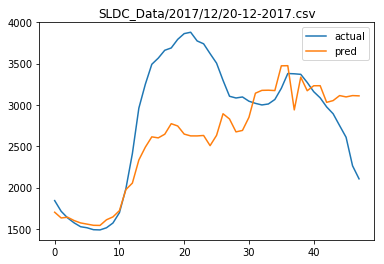

In [356]:
# prediction on test data
predict(test)

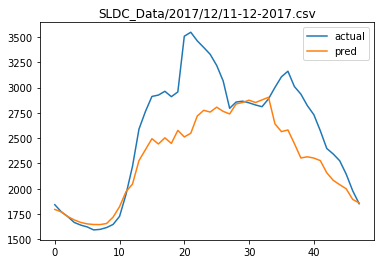

In [354]:
# prediction on train data
predict(train)

1957 2007


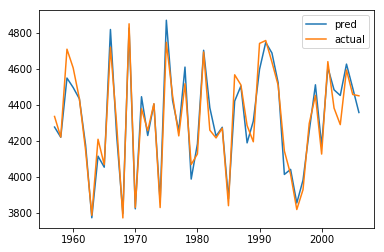

In [306]:
# prediction on train data as a whole

preds = model.predict(X_train)
preds = load_scaler.inverse_transform(preds)
Y_ = load_scaler.inverse_transform(Y_train)

x = np.random.randint(len(preds))
x_max = 50
print(x,x+x_max)
plt.plot(range(x, x+x_max), preds[x:x+x_max])
plt.plot(range(x, x+x_max), Y_[x:x+x_max])
plt.legend(['pred', 'actual'])
plt.show()